In [1]:
import os
from PIL import Image
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception


from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.activations import relu,softmax
from keras.initializers import he_normal,glorot_normal,random_normal,glorot_uniform
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta,Adam
from keras.utils import np_utils


import warnings
warnings.filterwarnings('ignore')


**TASKS TO BE DONE**

0.Run on small dataset

1.Find The Accuracy For Test using Test generator.

2.Decide The Hyperparameters and train the model.



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
class Fine_Tune:

  #target_size = (w x h x channel)
  def __init__(self,target_size,Conv2d_layers,num_neurons,num_filters,fo):
    self.model = Sequential()
    self.filters = num_filters
    self.fo = fo
    self.target_size = target_size
    self.num_neurons = num_neurons
    self.Conv2d_layers = Conv2d_layers

  def BUILD_MODEL(self,pretrained_model):
    if (pretrained_model == 'InceptionV3'):
      prt = InceptionV3(weights='imagenet',include_top=False,input_shape = self.target_size)
      
    elif (pretrained_model == 'InceptionResnetV2'):
      prt = InceptionResNetV2(weights='imagenet',include_top=False,input_shape = self.target_size)
     
    elif (pretrained_model == 'ResNet50'):
      prt = ResNet50(weights='imagenet',include_top=False,input_shape = self.target_size)
      
    else :
      prt = Xception(weights='imagenet',include_top=False,input_shape = self.target_size)

    #make every layer non trainable..
    for layer in prt.layers:
        layer.trainable = False

    self.model.add(prt)
    
    #add own convolution layers...
    cf = self.filters
    for i in range(self.Conv2d_layers):

      self.model.add(Conv2D(filters = cf , kernel_size = 3 ,use_bias= True))
      self.model.add(BatchNormalization())
      self.model.add(Activation('relu'))
      self.model.add(Dropout(0.2))
      self.model.add(MaxPooling2D(pool_size = (2,2)))

      cf*=self.fo

    #Add dense layers.. 
    self.model.add(Flatten())
    self.model.add(Dense(units = self.num_neurons))
    self.model.add(Activation('relu'))
    #self.model.add(Dropout(self.dropout))

    self.model.add(Dense(units=10))
    self.model.add(Activation('softmax'))

    self.model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

    return


  def Fit_Model(self,train_path,epochs,batch_size):
    tr_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split = 0.2)

    tr_gen = tr_datagen.flow_from_directory(
            directory = train_path,target_size = self.target_size,color_mode = 'rgb',       
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 10,
            subset = 'training'
            )

    val_gen = tr_datagen.flow_from_directory(
            directory = train_path,target_size = self.target_size,color_mode = 'rgb',
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            seed = 10,
            subset = 'validation'
            ) 

    step_size_train = tr_gen.n//tr_gen.batch_size
    step_size_valid = val_gen.n//val_gen.batch_size

    self.model.fit_generator(generator = tr_gen,
                          steps_per_epoch = step_size_train,
                          validation_data = val_gen,
                          validation_steps = step_size_valid,
                          epochs = epochs, verbose=1)
    return

  def Predict_Test(self,test_path):

    ts_datagen = ImageDataGenerator(rescale = 1./255)
    test_gen = ts_datagen.flow_from_directory(
        directory = test_path,
        target_size = self.target_size,
        color_mode = 'rgb',
        batch_size = 1,
        class_mode = None,
        shuffle = False,
        seed=10
        )
    
    step_size_test = test_gen.n//test_gen.batch_size
    test_gen.reset()

    print('Getting loss,accuracy for test data..')
    metrics = self.model.evaluate_generator(generator = test_gen,
                                             steps = step_size_test,verbose=1,
                                            )
    
    print('Getting predictions for test data..')
    pred = self.model.predict_generator(generator = test_gen,
                                  steps = step_size_test,
                                  verbose = 1
                                  )
    return (metrics,pred)

**Using InceptionV3 as pretrained model**

In [4]:
target_size = (256,256)
num_neurons = 128

obj1 = Fine_Tune(target_size=target_size ,
                 Conv2d_layers=0,            #if we have to add extra convolution layers..
                 num_neurons=num_neurons,
                 num_filters=32,
                 fo=0.5)                      #filter organisation.

obj1.BUILD_MODEL('InceptionV3')


87916544/87910968 [==============================] - 1s 0us/step


In [5]:
train_path = '/content/gdrive/MyDrive/inaturalist_12K/train'
obj1.Fit_Model(train_path,epochs=10,batch_size=32)

Found 8000 images belonging to 10 classes.
Found 1999 images belonging to 10 classes.
Epoch 1/10
250/250 [==============================] - 6362s 25s/step - loss: 5.4901 - accuracy: 0.4660 - val_loss: 1.0049 - val_accuracy: 0.6946
Epoch 2/10
250/250 [==============================] - 162s 650ms/step - loss: 0.8313 - accuracy: 0.7282 - val_loss: 1.0481 - val_accuracy: 0.6784
Epoch 3/10
250/250 [==============================] - 156s 623ms/step - loss: 0.5734 - accuracy: 0.8029 - val_loss: 1.0488 - val_accuracy: 0.7122
Epoch 4/10
250/250 [==============================] - 155s 622ms/step - loss: 0.4064 - accuracy: 0.8466 - val_loss: 0.9977 - val_accuracy: 0.7162
Epoch 5/10
250/250 [==============================] - 154s 615ms/step - loss: 0.3254 - accuracy: 0.8724 - val_loss: 1.1529 - val_accuracy: 0.7278
Epoch 6/10
250/250 [==============================] - 154s 616ms/step - loss: 0.2633 - accuracy: 0.8987 - val_loss: 1.3505 - val_accuracy: 0.7142
Epoch 7/10
250/250 [===================

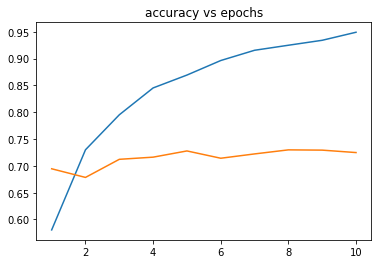

In [6]:
plt.plot(np.arange(1,11),obj1.model.history.history['accuracy'],label='train accuracy')
plt.plot(np.arange(1,11),obj1.model.history.history['val_accuracy'],label='val accuracy')
plt.title('accuracy vs epochs')
plt.show()

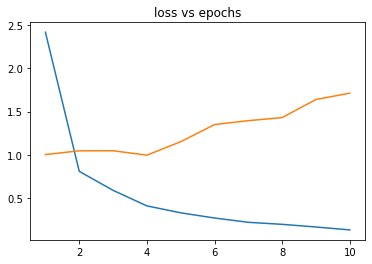

In [7]:
plt.plot(np.arange(1,11),obj1.model.history.history['loss'],label='train loss')
plt.plot(np.arange(1,11),obj1.model.history.history['val_loss'],label='val loss')
plt.title('loss vs epochs')
plt.show()

**1.Evaluate the accuracy for test**

In [9]:
test_path = '/content/gdrive/MyDrive/inaturalist_12K/val'
metrics , pred = obj1.Predict_Test(test_path)
print('test loss : ',metrics[0])
print('test accuracy : ',metrics[1])